In [30]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [31]:
stemmer = SnowballStemmer('english')

In [32]:
#functions

def word_tokenize(text, how = 'lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def spelling(text):
    words = TextBlob(text).words
    return [word.correct() for word in words]

## Exploratory Data Analysis

In [33]:
#load in csv files and preview training set

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_ids = train['id']
test_ids = test['id']

del train['id']
del test['id']

train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [34]:
#preview test set

test.head()

,comment_text
0,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,::Kentuckiana is colloquial. Even though the ...
2,"Hello fellow Wikipedians,\nI have just modifie..."
3,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,== [WIKI_LINK: Talk:Celts] ==


In [35]:
#train info

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95851 entries, 0 to 95850
Data columns (total 7 columns):
comment_text     95851 non-null object
toxic            95851 non-null int64
severe_toxic     95851 non-null int64
obscene          95851 non-null int64
threat           95851 non-null int64
insult           95851 non-null int64
identity_hate    95851 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.1+ MB


In [36]:
#how many rows of train and test

print('train = ' + str(train.shape))
print('test = ' + str(test.shape))

train = (95851, 7)
test = (226998, 1)


In [37]:
#counts

print('toxic = ' + str(train['toxic'].sum()))
print('severe toxic = ' + str(train['severe_toxic'].sum()))
print('obscene = ' + str(train['obscene'].sum()))
print('threat = ' + str(train['threat'].sum()))
print('insult = ' + str(train['insult'].sum()))
print('identity_hate = ' + str(train['identity_hate'].sum()))

toxic = 9237
severe toxic = 965
obscene = 5109
threat = 305
insult = 4765
identity_hate = 814


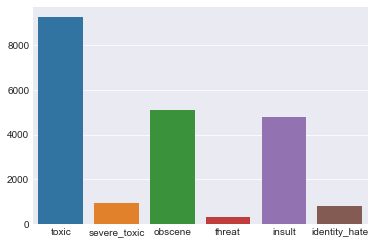

In [38]:
#distribution of toxic categories

sns.set_style('darkgrid')
sns.barplot(x = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], y = [9237, 965, 5109, 305, 4765, 814])

In [39]:
#define binary response for analysis, can see that comment can contain multiple tags

train['toxic_all'] = train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']
train.tail()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_all
95846,"""\nI have discussed it, unlike most of those w...",0,0,0,0,0,0,0
95847,"ps. Almost forgot, Paine don't reply back to t...",1,0,1,0,0,0,2
95848,Mamoun Darkazanli\nFor some reason I am unable...,0,0,0,0,0,0,0
95849,Salafi would be a better term. It is more poli...,0,0,0,0,0,0,0
95850,making wikipedia a better and more inviting pl...,0,0,0,0,0,0,0


In [49]:
#length of comment

print('average characters toxic = ' + str(np.mean(len(train.comment_text[train['toxic_all'] >= 1]))))
print('average characters non-toxic = ' + str(np.mean(len(train.comment_text[train['toxic_all'] == 0]))))

average characters toxic = 9790.0
average characters non-toxic = 86061.0


(-0.5, 399.5, 199.5, -0.5)

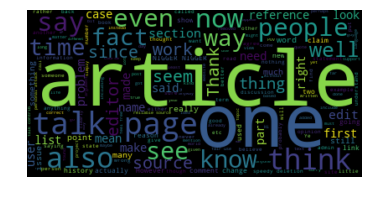

In [17]:
#generate and plot wordclouds

wordcloud = WordCloud().generate(' '.join(train['comment_text']))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

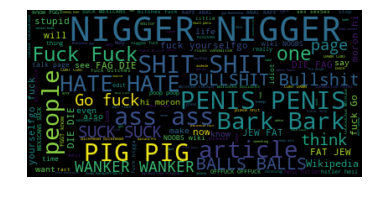

In [18]:
#toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['toxic'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

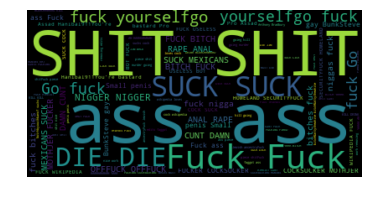

In [19]:
#severe toxic wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['severe_toxic'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

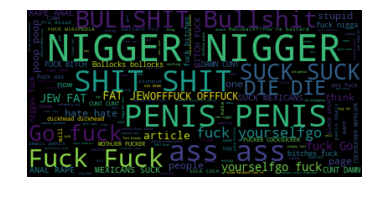

In [20]:
#obscene wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['obscene'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

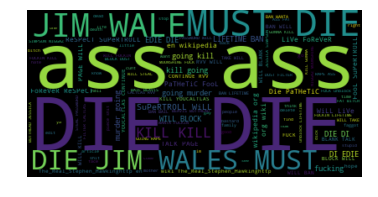

In [22]:
#threat wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['threat'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

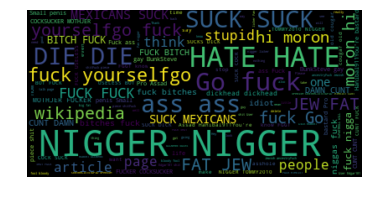

In [23]:
#insult wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['insult'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

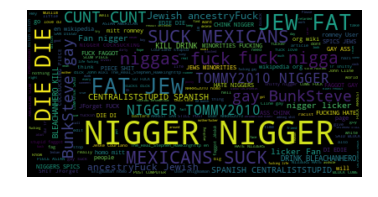

In [24]:
#identity hate wordcloud

wordcloud = WordCloud().generate(' '.join(train.comment_text[train['identity_hate'] == 1]))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")

In [9]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(train['comment_text'], train.iloc[:,1:], random_state = 1)
x_train.head()

8995     "\n\n Roseville mall \n\nHappy New Year, Mike!...
46615    Here is a reputable link from 9 minutes ago re...
3068     If a person has right to comment at any page t...
5905     " 2009 (UTC)\n\nIt does now. ₪—  (T·C) "" 17:5...
2914     Rugby questions\nHi, I mainly find info on Sta...
Name: comment_text, dtype: object

In [10]:
#insantiate and fit transform count vectorizer (term frequency)

vect = CountVectorizer()
x_train_dtm = vect.fit_transform(x_train)